In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import date, timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from datetime import date
from dateutil.relativedelta import relativedelta

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [57]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

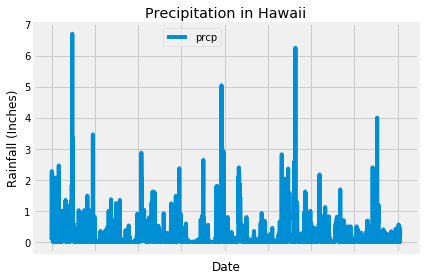

<Figure size 432x288 with 0 Axes>

In [98]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

last_date = session.query(Measurement).order_by(Measurement.date.desc()).limit(1)

for date in last_date:
    most_last_date = date.date

most_last_date = dt.datetime.strptime(most_last_date, "%Y-%m-%d")
    
first_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

precp_year = session.query(Measurement.date, Measurement.prcp).\
                        filter(Measurement.date > first_date).\
                        order_by(Measurement.date).all()
# Calculate the date 1 year ago from the last data point in the database

one_year_ago = most_last_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

precp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(precp_data).dropna()
df_=df.set_index("date",inplace=True)
df.head()

# Sort the dataframe by date

df = df.sort_values(['date'])
df.head()

# Use Pandas Plotting with Matplotlib to plot the data

df.plot()
plt.title("Precipitation in Hawaii")
plt.xlabel('Date')
plt.ylabel('Rainfall (Inches)')
plt.legend(bbox_to_anchor=(0.5, 1.00))
plt.xticks(rotation='90')
plt.tight_layout()
plt.show()
fig = plt.figure()
#plt.savefig("Images/Precipitation.png")

![precipitation](Images/precipitation.png)

In [99]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [100]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).distinct().count()
print(f'There are {stations} stations available in this dataset.')

There are 9 stations available in this dataset.


In [108]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = session.query(Measurement.station,func.count(Measurement.station)).\
            group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [111]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

station_stats = session.query(Measurement.station, 
                                    func.count(Measurement.station).label('count')).\
                                    group_by(Measurement.station).\
                                    order_by(func.count(Measurement.station).desc()).limit(1)[0][0]
                                    

sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
                
session.query(*sel).filter(Measurement.station==station_stats).all()

[(54.0, 85.0, 71.66378066378067)]

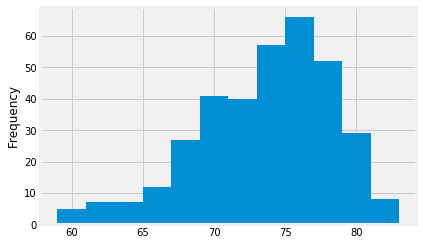

In [113]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs = session.query(Measurement.tobs).\
                                filter(Measurement.station==most_active_station).\
                                filter(Measurement.date >= one_year_ago).\
                                order_by(Measurement.date.desc()).all()

x = [x[0] for x in temp_obs]


plt.hist(x, bins=12)
plt.ylabel('Frequency')
plt.show()
#plt.savefig("Images/Station-Histogram.png")

![precipitation](Images/station-histogram.png)

In [116]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [136]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2017-01-01', '2017-01-10')
trip_temps


[(60.0, 68.0327868852459, 77.0)]

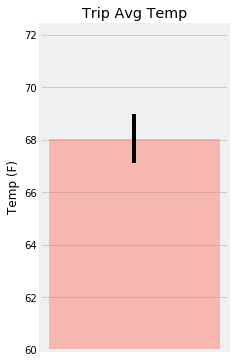

In [127]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
lower = trip_temps[0][1] - trip_temps[0][0]
upper = trip_temps[0][2] - trip_temps[0][1]

plt.figure(figsize=(3,6))
plt.bar(0, trip_temps[0][1], yerr=[upper-lower], color='salmon', alpha=0.5)
plt.title('Trip Avg Temp')
plt.xticks([])
plt.ylabel('Temp (F)')
plt.ylim(60)

plt.show()

In [134]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def rainfall(start_date, end_date):
    return session.query(Measurement.station, 
                         Measurement.prcp.label('rainfall'),
                         Station.latitude,
                         Station.longitude,
                         Station.elevation).\
                            group_by(Measurement.station).\
                            join(Station, Measurement.station == Station.station).\
                            filter(Measurement.date >= start_date).\
                            filter(Measurement.date <= end_date).\
                            order_by(Measurement.prcp.desc()).all()

rainfall('2017-01-01', '2017-01-10')

[('USC00513117', 0.0, 21.4234, -157.8015, 14.6),
 ('USC00514830', 0.0, 21.5213, -157.8374, 7.0),
 ('USC00516128', 0.0, 21.3331, -157.8025, 152.4),
 ('USC00519281', 0.0, 21.45167, -157.84888999999998, 32.9),
 ('USC00519397', 0.0, 21.2716, -157.8168, 3.0),
 ('USC00519523', 0.0, 21.33556, -157.71139, 19.5),
 ('USC00517948', None, 21.3934, -157.9751, 11.9)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [140]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-01-01'
end_date ='2017-01-10'

# Use the start and end date to create a range of dates
dates = session.query(Measurement.date).filter(Measurement.date >= start_date).\
            filter(Measurement.date <= end_date).group_by(Measurement.date).all()
trip_dates = [x[0] for x in dates]

# Stip off the year and save a list of %m-%d strings

trip_dates_stripped= [x[5:] for x in trip_dates]

start_month_day = trip_dates_stripped[0]
end_month_day = trip_dates_stripped[-1]


# Loop through the list of %m-%d strings and calculate the normals for each date

daily_normals = [session.query(func.min(Measurement.tobs),func.avg(Measurement.tobs),\
                       func.max(Measurement.tobs)).filter(func.strftime("%m-%d", Measurement.date) >= start_month_day).\
                 filter(func.strftime("%m-%d", Measurement.date) <= end_month_day).\
                 group_by(func.strftime("%m-%d", Measurement.date)).all()]

daily_normals = daily_normals[0]

print("Aggregate Daily Normals for 01-01 to 01-10")
daily_normals

Aggregate Daily Normals for 01-01 to 01-10


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0),
 (57.0, 67.16071428571429, 75.0),
 (58.0, 67.9298245614035, 78.0),
 (62.0, 69.74137931034483, 77.0)]

In [142]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

# Create a dataframe from the previous query 
daily_normals_df= pd.DataFrame(daily_normals,columns=['tmin', 'tavg', 'tmax'])

# Add trip_dates to Pandas DataFrame
daily_normals_df['date']= trip_dates

# Change datatype from element to datetime object on Pandas, makes x axis title to add 
daily_normals_df['date'] = pd.to_datetime(daily_normals_df['date'], format='%Y-%m-%d')

# Set index to date
daily_normals_df.set_index('date',inplace=True)

daily_normals_df


,tmin,tavg,tmax
date,,,
2017-01-01,62.0,69.153846,77.0
2017-01-02,60.0,69.396226,77.0
2017-01-03,62.0,68.909091,77.0
2017-01-04,58.0,70.000000,76.0
2017-01-05,56.0,67.964286,76.0
2017-01-06,61.0,68.964912,76.0
2017-01-07,57.0,68.543860,76.0
2017-01-08,57.0,67.160714,75.0
2017-01-09,58.0,67.929825,78.0


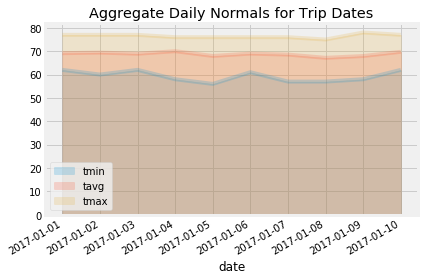

In [144]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot(kind='area', alpha=.2, stacked=False, x_compat=True, title="Aggregate Daily Normals for Trip Dates")
plt.tight_layout()
#plt.savefig("Images/DailyNormals.png")
plt.show()